In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader  # Load the data
from torch.utils.tensorboard import SummaryWriter  # Show the Tensorboard
import cv2
import os
from matplotlib import pyplot as plt
from glob import glob
import random
import numpy as np
from math import ceil

In [5]:
print(torch.cuda.is_available())

True


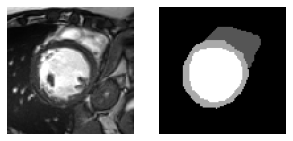

True

In [6]:
def show_image_mask(img, mask, cmap='gray'):  # visualisation
    fig = plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
data_dir = '/content/drive/My Drive/data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

# **1 DataImport**

In [7]:
################################################################################
class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root, 'mask', basename[:-4] + '_mask.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)


class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)
################################################################################

# **2 CNN Structure**

In [12]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

class UNet_3Plus(nn.Module):

    def __init__(self, in_channels=1, n_classes=4, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

# **4 Functions of Training, Validation**

## Parameter Setting

In [13]:
# Network Established 
net = UNet_3Plus().cuda()


# The Hyperparameter that Optimized
batchsize=4
learningrate=1e-5



# Using decreaseing learning rate tuning
from torch.optim.lr_scheduler import ReduceLROnPlateau
min_learningrate=1e-12
lr_patience=10


# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learningrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
best_val_loss = 0.2

#RMSprop(net.parameters(), lr=learningrate, weight_decay=1e-8, momentum=0.9)




# Data Load
train_data_path = '/content/drive/My Drive/data/train'
train_set = TrainDataset(train_data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=batchsize, shuffle=True)
valid_data_path = '/content/drive/My Drive/data/val'
valid_set = TrainDataset(valid_data_path)
valid_data_loader = DataLoader(dataset=valid_set, num_workers=4, batch_size=batchsize, shuffle=False)

model_data_path = '/content/drive/My Drive/data/model'

writer_path = os.path.join(model_data_path,'UNet_3Plus/log')
# Record training process ( basically for ploting figure )
writer = SummaryWriter(writer_path)

## AverageMeter and Validation Func

In [14]:
# Calculate average value of current batch
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


####
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask.cpu().numpy()].cpu().numpy().astype(int)+
        label_pred[mask.cpu().numpy()], 
        minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

###
def evaluate(predictions, gts, num_classes):
    hist = np.zeros((num_classes, num_classes))
    for lp, lt in zip(predictions, gts):
        hist += _fast_hist(lp.flatten(), lt.flatten(), num_classes)
    # axis 0: gt, axis 1: prediction
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

## Training Sec

In [15]:
def train(training_data_loader, net, loss_function, optimizer,epoch):
  # Change model status as Training Mode
    net.train()
    train_loss = AverageMeter()
    curr_iter = (epoch - 1) * len(training_data_loader)
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        img=img.unsqueeze(1).cuda() # adding 1 channel
        mask=mask.cuda()

        N = img.size(0)           # number of batch
        optimizer.zero_grad()     # CLEAR GRADIENT BUFFER
        outputs = net(img)        # FORWARD
        loss = loss_function(outputs, mask.to(dtype=torch.int64)) / N # mask type need to be long
        loss.backward()           # BACKWORD
        optimizer.step()          # UPDATE GRADIENT

        train_loss.update(loss.data.item(),N) # Average loss of this loop
        curr_iter += 1
        writer.add_scalar('train_loss', train_loss.avg, curr_iter)

        if (iteration + 1) % 10 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (
                  epoch+1, iteration + 1, len(training_data_loader), train_loss.avg
        ))
    return train_loss.avg

## Validation sec

In [16]:
def validation(valid_data_loader, net, loss_function, optimizer, epoch):
    # Model Status as Evaluation Mode
    net.eval()
    val_loss = AverageMeter()
    img_all, mask_all, predictions_all = [], [], []

    for iteration, sample in enumerate(valid_data_loader): 
        img, mask = sample
        img=img.unsqueeze(1).cuda() # adding 1 channel
        mask=mask.to(dtype=torch.int64).cuda()# mask should be long type

        N = img.size(0)           # number of data
        outputs = net(img)        # FORWARD
        # Take max over 1D, return [[max of each row], [index of each max]]
        # Get the Max values index
        predictions = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy() 

        val_loss.update(loss_function(outputs, mask).data.item()/ N, N)
        
        with torch.no_grad():
            mask.squeeze_(0).cpu().numpy()
        mask_all.append(mask)
        predictions_all.append(predictions)
    # Accuracy, Accuracy of each columns , Mean IU, Frequency Weighted Intersection
    # Acc = Correct/Totall
    # Acc_cls = Accuracy of each class
    # IU is Recall, Mean_IU is mean Recall
    # Fwavacc is frequency times Recall
    acc, acc_cls, mean_iu, fwavacc = evaluate(predictions_all, mask_all, 4)# Number of class=4

    writer.add_scalar('val_loss', val_loss.avg, epoch)
    writer.add_scalar('acc', acc, epoch)
    writer.add_scalar('acc_cls', acc_cls, epoch)
    writer.add_scalar('mean_iu', mean_iu, epoch)
    writer.add_scalar('fwavacc', fwavacc, epoch)
    #writer.add_scalar('lr', optimizer.param_groups[1]['lr'], epoch)
    
    print('====================================================================')
    print('[epoch %d], [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f]' % (
        epoch+1, val_loss.avg, acc, acc_cls, mean_iu, fwavacc))
    print('====================================================================')

    return val_loss.avg

# **5 Training and validating**

In [17]:
# Epochs
epochs=200


#Training and Validation
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=lr_patience, min_lr=min_learningrate, verbose=True)# With Learning Decreasing
for epoch in range(epochs):
    PATH = os.path.join(model_data_path, 'UNet_3Plus/Bestmodel_epoch_'+ str(epoch)+'.pth')
    train_loss = train(training_data_loader, net, loss_function, optimizer,epoch)
    val_loss = validation(valid_data_loader, net, loss_function, optimizer, epoch)
    # Draw train val map
    writer.add_scalars('train/val loss', {
                                        'train_loss':train_loss,
                                        'val_loss':val_loss}, epoch)
    # Save the best model
    if val_loss < best_val_loss:
        print(f"Model Saved at {PATH}")
        best_val_loss = val_loss
        torch.save(net.state_dict(), PATH)
    scheduler.step(val_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch 1], [iter 10 / 25], [train loss 0.35233]
[epoch 1], [iter 20 / 25], [train loss 0.33730]
[epoch 1], [val loss 0.34744], [acc 0.43650], [acc_cls 0.58387], [mean_iu 0.21619], [fwavacc 0.35230]
[epoch 2], [iter 10 / 25], [train loss 0.29440]
[epoch 2], [iter 20 / 25], [train loss 0.28719]
[epoch 2], [val loss 0.28121], [acc 0.72641], [acc_cls 0.73262], [mean_iu 0.40908], [fwavacc 0.65413]
[epoch 3], [iter 10 / 25], [train loss 0.26323]
[epoch 3], [iter 20 / 25], [train loss 0.26050]
[epoch 3], [val loss 0.25963], [acc 0.82012], [acc_cls 0.76994], [mean_iu 0.49694], [fwavacc 0.75623]
[epoch 4], [iter 10 / 25], [train loss 0.24608]
[epoch 4], [iter 20 / 25], [train loss 0.24379]
[epoch 4], [val loss 0.24419], [acc 0.87089], [acc_cls 0.77241], [mean_iu 0.55430], [fwavacc 0.81359]
[epoch 5], [iter 10 / 25], [train loss 0.23423]
[epoch 5], [iter 20 / 25], [train loss 0.23243]
[epoch 5], [val loss 0.23575], [acc 0.89270], [acc_cls 0.78847], [mean_iu 0.59170], [fwavacc 0.83911]
[epoch 6],

In [ ]:
! tensorboard --logdir=writer_path --host localhost --port 8088

2020-12-17 17:01:56.793448: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorBoard 2.3.0 at http://localhost:8088/ (Press CTRL+C to quit)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.6/concurrent/futures/thread.py", line 33, in _python_exit
    def _python_exit():
KeyboardInterrupt


# Testing

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


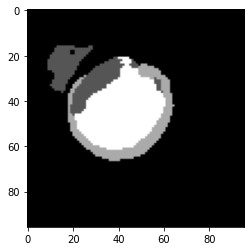

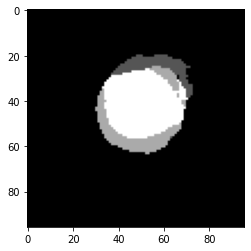

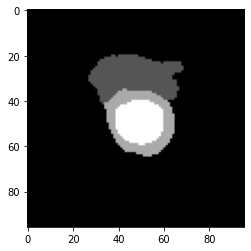

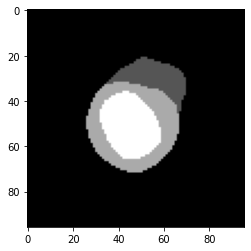

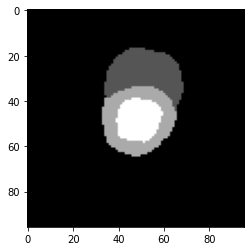

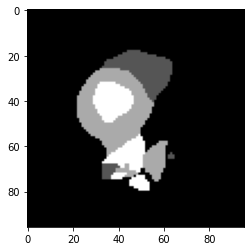

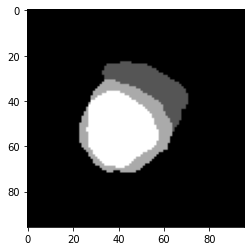

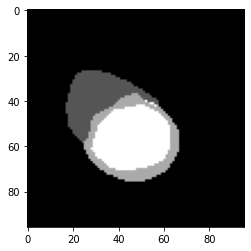

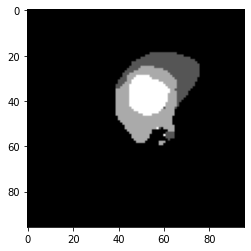

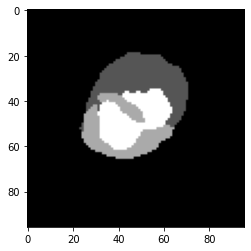

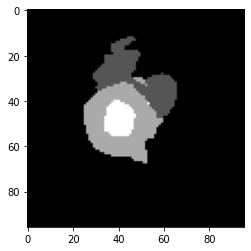

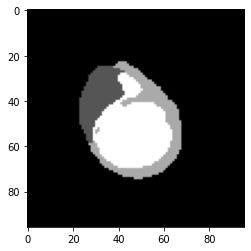

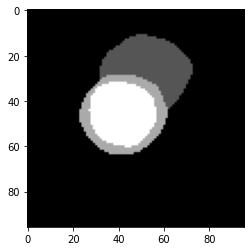

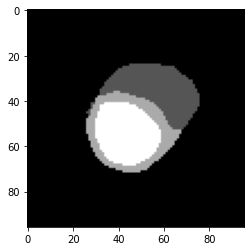

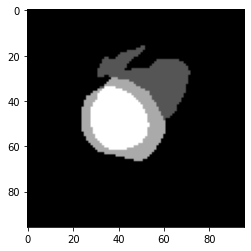

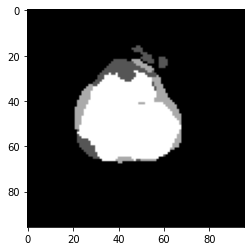

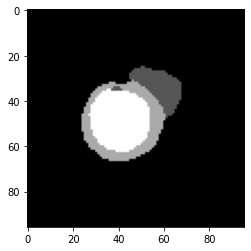

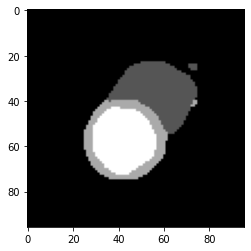

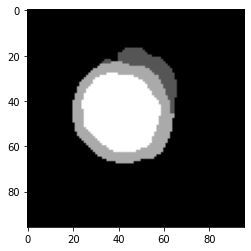

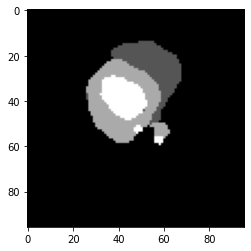

In [20]:
test_data_path = '/content/drive/My Drive/data/test'
test_set = TestDataset(test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=4, batch_size=batchsize, shuffle=False)
PATH = os.path.join(model_data_path,'UNet_3Plus', 'Bestmodel_epoch_131'+'.pth')

net.load_state_dict(torch.load(PATH))
net.eval()
val_loss = AverageMeter()
batchsize=4
learningrate=1e-5


# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learningrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


for iteration, sample in enumerate(test_data_loader):
    img= sample
    img=img.unsqueeze(1).cuda() # adding 1 channel
    #mask=mask.to(dtype=torch.int64).cuda()# mask should be long type

    outputs = net(img)
    predictions = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
    plt.imshow(predictions[0,...],cmap='gray')
    plt.pause(0.1)